# Results Processing

## Imports and variables used throughout file

Load results dataframe from pickle file

In [ ]:
from dir_paths import PROCESSED_DATA_DIR, FIGURES_SIMULATIONS_DIR, TABLES_DIR
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
import numpy as np

# Configure matplotlib to use LaTeX
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize": [10, 6],
    "savefig.dpi": 300,
    "savefig.format": "pdf"
})

AXIS_FONT_SIZE = 14
TITLE_FONT_SIZE = 16
TICKS_FONT_SIZE = 14
LEGEND_FONT_SIZE = 14

# Set default font sizes for all matplotlib plots using rcParams
mpl.rcParams['axes.labelsize'] = AXIS_FONT_SIZE
mpl.rcParams['axes.titlesize'] = TITLE_FONT_SIZE
mpl.rcParams['xtick.labelsize'] = TICKS_FONT_SIZE
mpl.rcParams['ytick.labelsize'] = TICKS_FONT_SIZE
mpl.rcParams['legend.fontsize'] = LEGEND_FONT_SIZE
mpl.rcParams['legend.title_fontsize'] = LEGEND_FONT_SIZE

# Map algs to different colors
FIFO_COLOR = '#1f77b4'
LRU_COLOR = '#ff7f0e'
SIEVE_COLOR = '#2ca02c'

ALGORITHM_COLORS = {
    'FIFO': FIFO_COLOR,
    'LRU': LRU_COLOR,
    'SIEVE': SIEVE_COLOR
}

# Load results_df from pickle file
results_df = pd.read_pickle(f"{PROCESSED_DATA_DIR}/results_df.pkl")

## Miss ratio vs. relative cache size

### Stats

In [ ]:
# Overview table: Mean miss ratio by algorithm and relative cache size
print("=== MEAN MISS RATIO OVERVIEW TABLE ===")
print("Mean Miss Ratio by Algorithm and Relative Cache Size")
print("=" * 70)

# Create pivot table with mean miss ratios
overview_table = results_df.pivot_table(
    values='miss_ratio', 
    index='cache_size_relative_rounded', 
    columns='algorithm', 
    aggfunc='mean'
).round(4)

# Display the table with proper formatting
print(f"{'Cache Size':<12} ", end="")
for algo in overview_table.columns:
    print(f"{algo:<10} ", end="")
print()
print("-" * 70)

for cache_size, row in overview_table.iterrows():
    print(f"{cache_size:<12.4f} ", end="")
    for algo in overview_table.columns:
        value = row[algo]
        if pd.isna(value):
            print(f"{'N/A':<10} ", end="")
        else:
            print(f"{value:<10.4f} ", end="")
    print()

print("=" * 70)

# Summary statistics for the table
print(f"\nTABLE SUMMARY:")
print(f"Number of cache sizes: {len(overview_table.index)}")
print(f"Number of algorithms: {len(overview_table.columns)}")
print(f"Cache size range: {overview_table.index.min():.4f} - {overview_table.index.max():.4f}")

# Show overall algorithm performance ranking
print(f"\nOVERALL ALGORITHM RANKING (by mean miss ratio):")
overall_means = overview_table.mean().sort_values()
print(f"{'Rank':<6} {'Algorithm':<12} {'Mean Miss Ratio':<16}")
print("-" * 35)
for rank, (algo, mean_miss) in enumerate(overall_means.items(), 1):
    print(f"{rank:<6} {algo:<12} {mean_miss:<16.4f}")

print(f"\n" + "=" * 70)

=== MEAN MISS RATIO OVERVIEW TABLE ===
Mean Miss Ratio by Algorithm and Relative Cache Size
Cache Size   FIFO       LRU        SIEVE      
----------------------------------------------------------------------
0.0001       0.9976     0.9976     0.9971     
0.0002       0.9910     0.9909     0.9846     
0.0004       0.9701     0.9689     0.9525     
0.0008       0.9457     0.9397     0.9045     
0.0010       0.9091     0.9014     0.8665     
0.0020       0.8487     0.8293     0.7744     
0.0030       0.8114     0.7858     0.7223     
0.0040       0.7860     0.7576     0.6906     
0.0080       0.7256     0.6953     0.6284     
0.0100       0.7067     0.6767     0.6110     
0.0200       0.6494     0.6212     0.5603     
0.0300       0.6159     0.5889     0.5316     
0.0400       0.5915     0.5653     0.5107     
0.0800       0.5278     0.5032     0.4568     
0.1000       0.5048     0.4806     0.4374     
0.2000       0.4205     0.3975     0.3659     
0.3000       0.3581     0.3362     0.3

### Violin plots

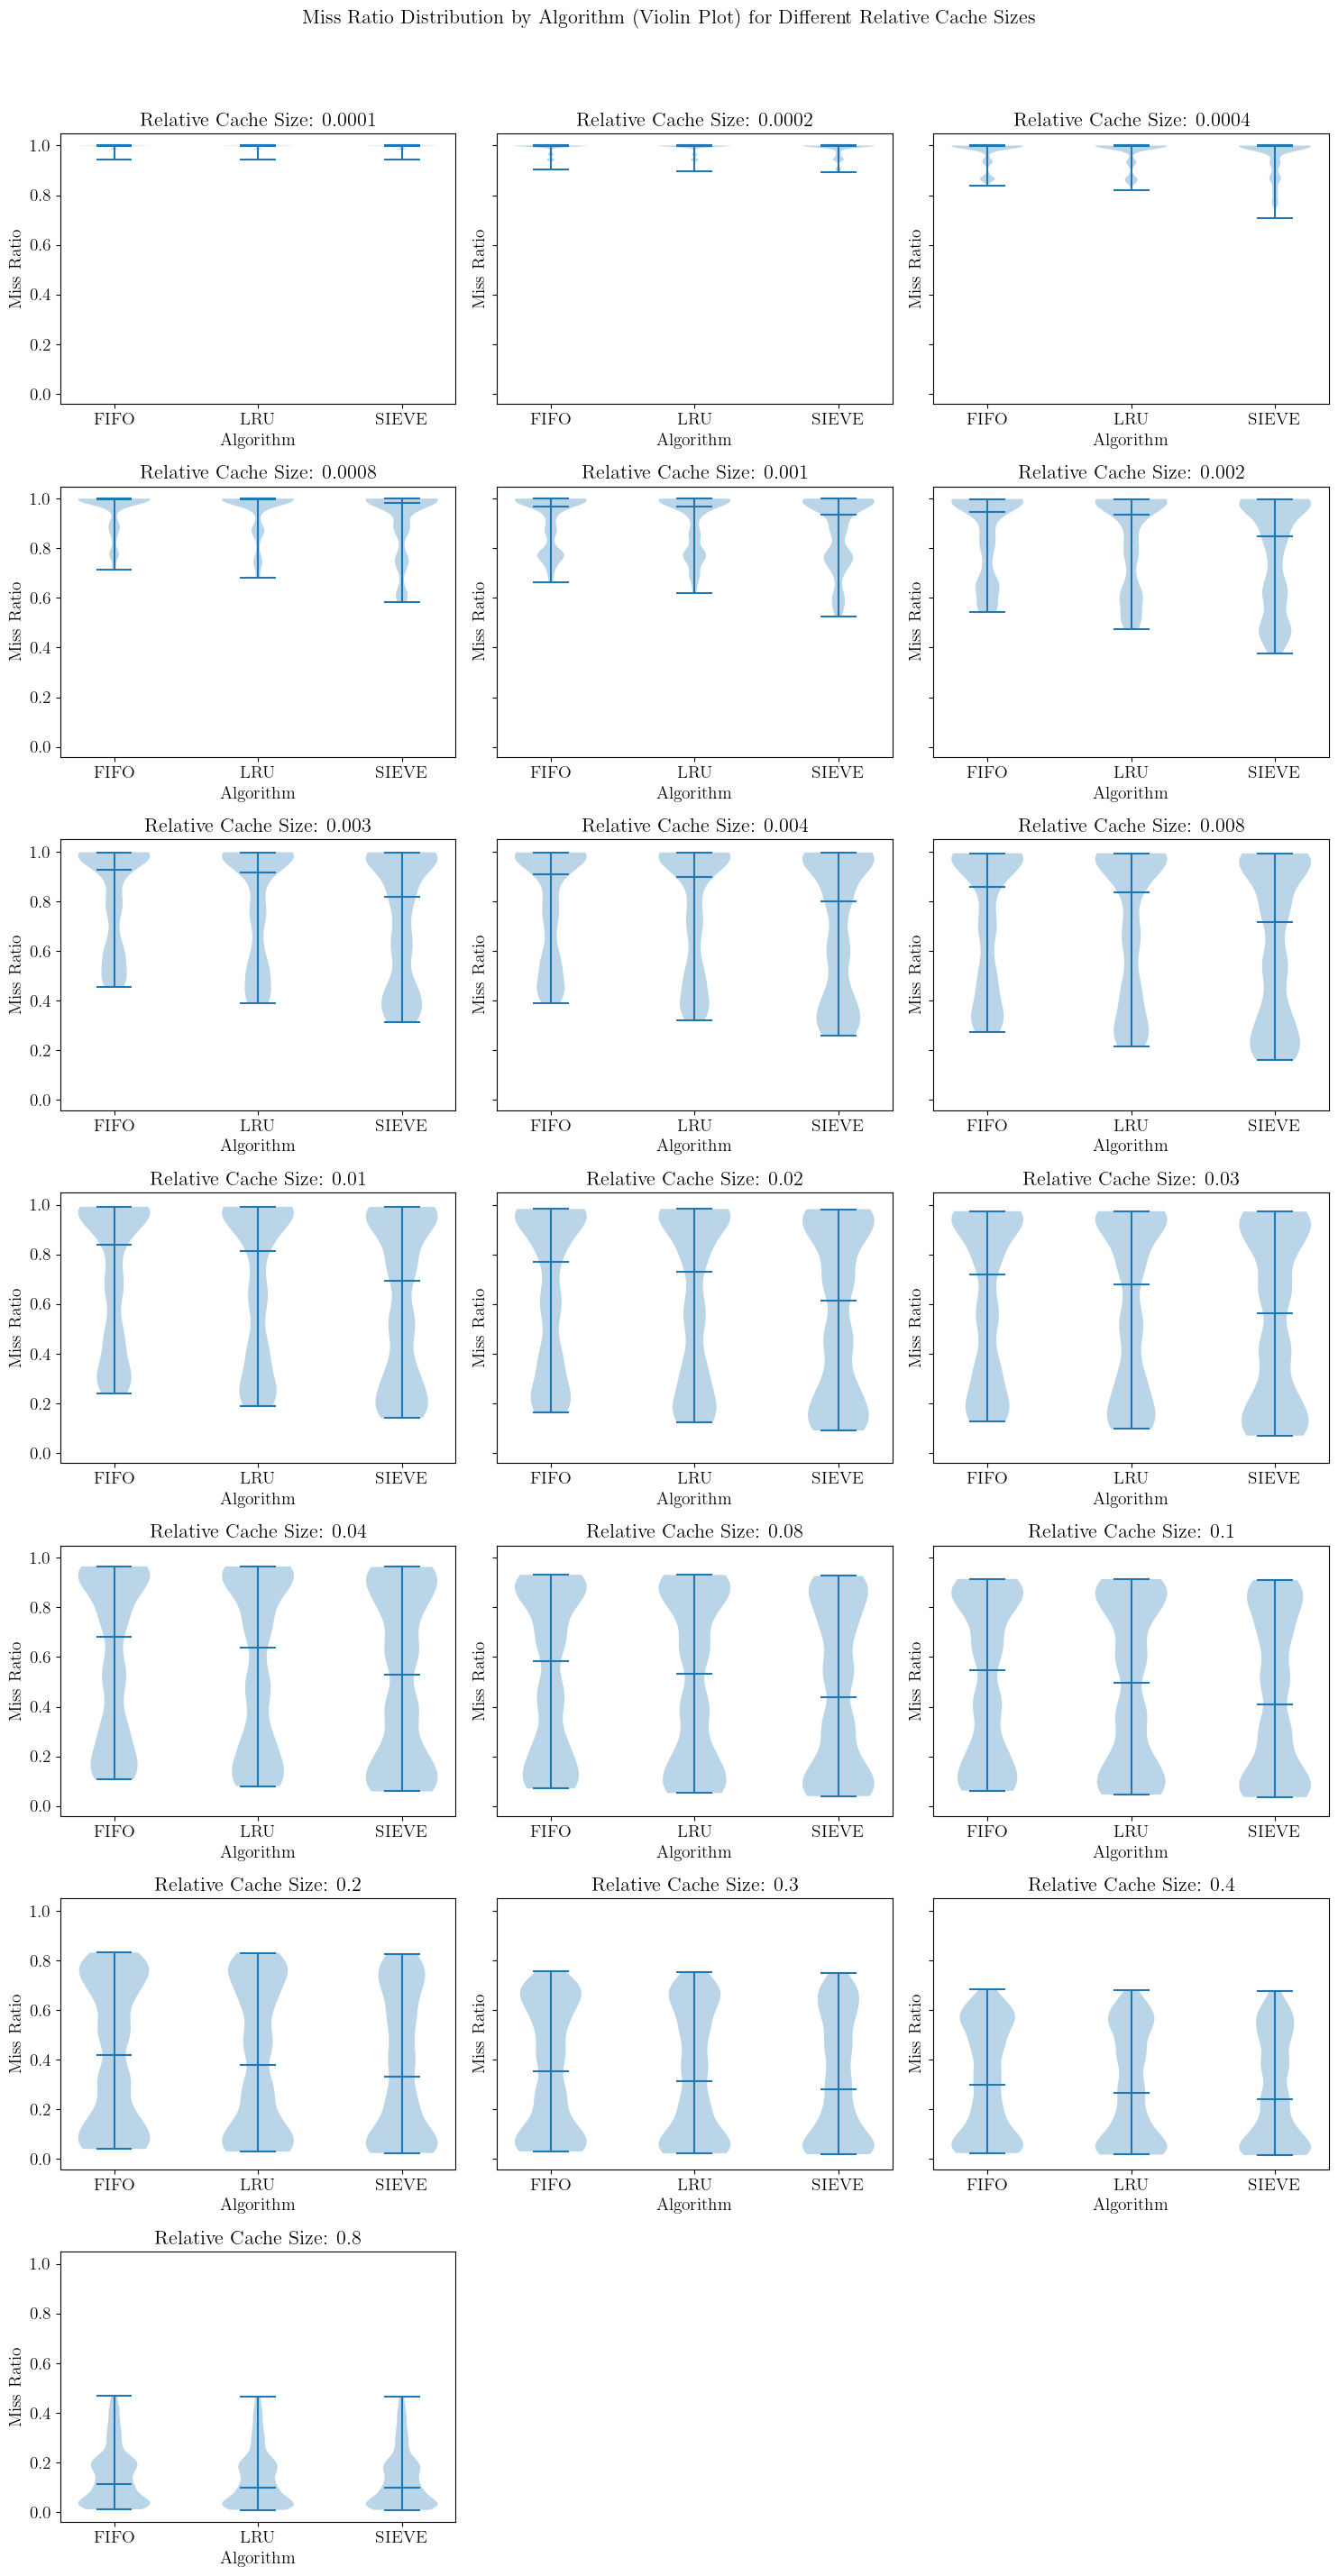

In [3]:
# Violin plots for miss ratio distribution by algorithm for each cache size
unique_sizes = sorted(results_df['cache_size_relative_rounded'].unique())
n_sizes = len(unique_sizes)
n_cols = 3
n_rows = (n_sizes + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), sharey=True)
axs = axs.flatten()

for i, size in enumerate(unique_sizes):
    subset = results_df[results_df['cache_size_relative_rounded'] == size]
    ax = axs[i]
    subset_violin = [subset[subset['algorithm'] == algo]['miss_ratio'] for algo in subset['algorithm'].unique()]
    ax.violinplot(subset_violin, showmeans=False, showmedians=True)
    ax.set_xticks(range(1, len(subset['algorithm'].unique()) + 1))
    ax.set_xticklabels(subset['algorithm'].unique())
    ax.set_title(f'Relative Cache Size: {size}')
    ax.set_xlabel('Algorithm')
    ax.set_ylabel('Miss Ratio')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle('Miss Ratio Distribution by Algorithm (Violin Plot) for Different Relative Cache Sizes', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### Boxplot per relative cache size

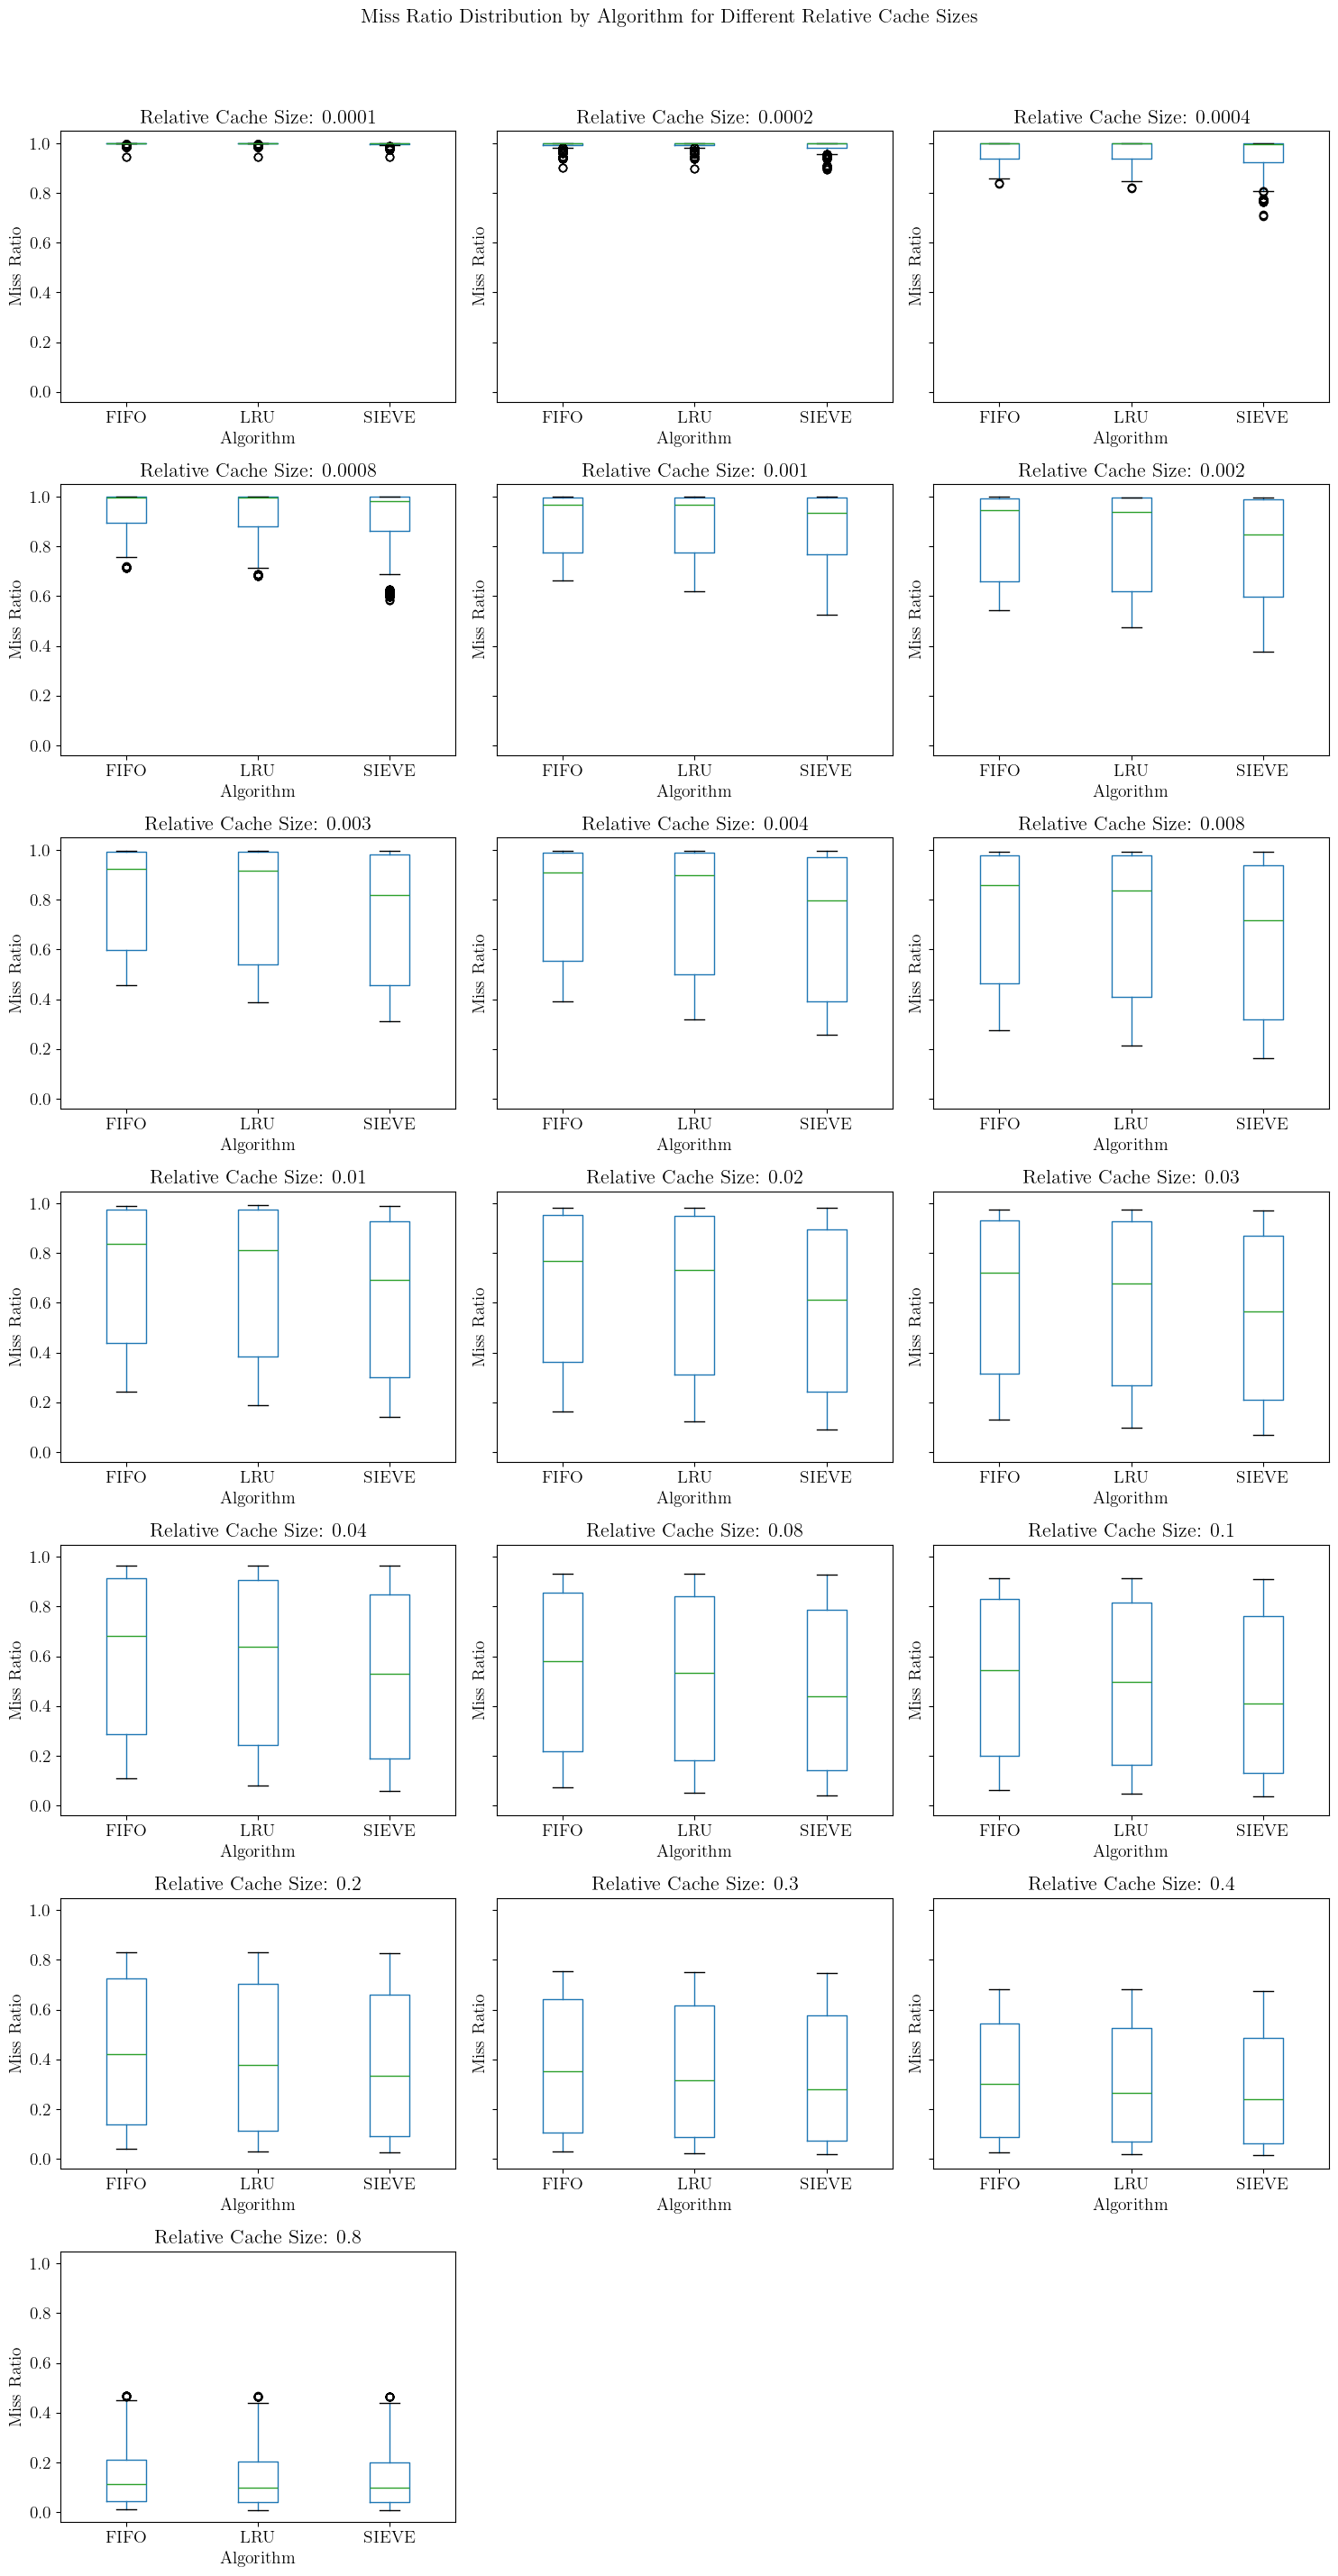

In [4]:
# Plot miss ratio distribution per algorithm for each relative cache size using boxplots and violin plots
unique_sizes = sorted(results_df['cache_size_relative_rounded'].unique())
n_sizes = len(unique_sizes)
n_cols = 3
n_rows = (n_sizes + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), sharey=True)
axs = axs.flatten()

for i, size in enumerate(unique_sizes):
    subset = results_df[results_df['cache_size_relative_rounded'] == size]
    ax = axs[i]
    subset.boxplot(column='miss_ratio', by='algorithm', ax=ax, grid=False)
    ax.set_title(f'Relative Cache Size: {size}')
    ax.set_xlabel('Algorithm')
    ax.set_ylabel('Miss Ratio')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle('Miss Ratio Distribution by Algorithm for Different Relative Cache Sizes', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### Line plot (linear + log)

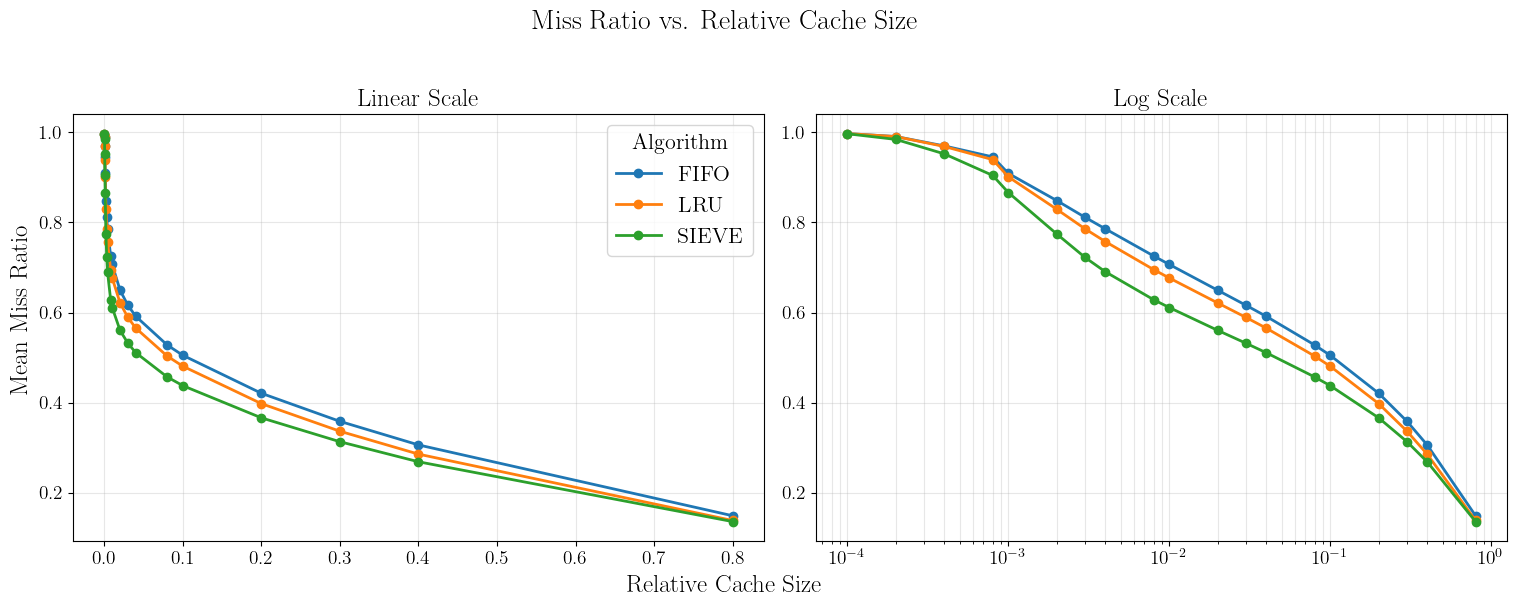

In [38]:
# Group by algorithm and cache_size_relative_rounded, aggregate mean miss ratio
agg_mean = results_df.groupby(['algorithm', 'cache_size_relative_rounded'])['miss_ratio'].mean().reset_index()
filenames = {"both" : "miss_ratio_vs_cache_size_both.pdf",
             "log" : "miss_ratio_vs_cache_size_log.pdf",
             "linear" : "miss_ratio_vs_cache_size_linear.pdf"}

def plot_miss_ratio_vs_cache_size(
    agg_df,
    scale='both',
    figsize=(16, 6),
    marker='o',
    save_fig=False,
    show_title=True
):
    """
    Plot miss ratio vs. relative cache size without error bars.

    Parameters:
        agg_df (pd.DataFrame): Aggregated dataframe with columns ['algorithm', 'cache_size_relative_rounded', 'miss_ratio']
        scale (str): 'linear', 'log', or 'both'
        figsize (tuple): Figure size
        marker (str): Marker style
    """
    
    def plot_miss_ratio_curves(ax, agg_df, log_scale=False, axis_labels=True, show_legend=True, legend_font=16):
        for algo in agg_df['algorithm'].unique():
            df_algo = agg_df[agg_df['algorithm'] == algo]
            ax.plot(
                df_algo['cache_size_relative_rounded'],
                df_algo['miss_ratio'],
                marker=marker,
                linewidth=2,
                label=algo,
                color=ALGORITHM_COLORS.get(algo, 'black')
            )
        if axis_labels:
            ax.set_xlabel(f"Relative Cache Size{' (log)' if log_scale else ''}", fontsize=16)
            ax.set_ylabel(f"Mean Miss Ratio", fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.grid(True, alpha=0.3, which='both')
        if show_legend:
            ax.legend(title="Algorithm", fontsize=legend_font, title_fontsize=legend_font)
        if log_scale:
            ax.set_xscale('log')

    if scale == "both":
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        # Plot linear scale
        plot_miss_ratio_curves(axes[0], agg_df, log_scale=False, axis_labels=False, legend_font=16)
        plot_miss_ratio_curves(axes[1], agg_df, log_scale=True, axis_labels=False, show_legend=False)
        axes[0].set_title("Linear Scale", fontsize=18)
        axes[1].set_title("Log Scale", fontsize=18)

        # Set shared x and y labels
        fig.text(0.5, 0.04, "Relative Cache Size", ha='center', va='center', fontsize=18)
        fig.text(0.06, 0.5, "Mean Miss Ratio", ha='center', va='center', rotation='vertical', fontsize=18)

        if show_title:
            fig.suptitle("Miss Ratio vs. Relative Cache Size", fontsize=20, y=1)
        plt.tight_layout(rect=[0.06, 0.04, 1, 0.97])
        if save_fig:
            plt.savefig(os.path.join(FIGURES_SIMULATIONS_DIR, filenames[scale]), bbox_inches='tight')
        plt.show()

    else:
        fig, ax = plt.subplots(figsize=(10, 6))
        plot_miss_ratio_curves(ax, agg_df, log_scale=(scale == "log"))
        if show_title: 
            ax.set_title(f"Miss Ratio vs. Relative Cache Size{' (log)' if scale == 'log' else ''}", fontsize=18)
        plt.tight_layout()
        if save_fig:
            filename = filenames.get(scale, f"miss_ratio_vs_cache_size_{scale}.pdf")
            plt.savefig(os.path.join(FIGURES_SIMULATIONS_DIR, filename), bbox_inches='tight')
        plt.show()

plot_miss_ratio_vs_cache_size(agg_mean, scale='both', save_fig=False, show_title=True)

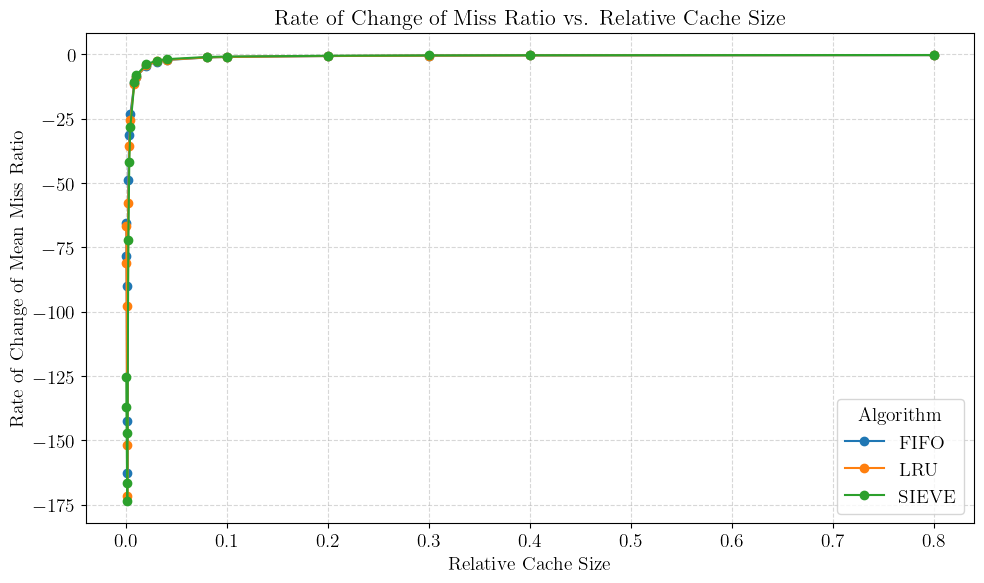

In [35]:
# Plot the rate of change (derivative) of mean miss ratio with respect to relative cache size for each algorithm

plt.figure(figsize=(10, 6))

for algo in agg_mean['algorithm'].unique():
    df_algo = agg_mean[agg_mean['algorithm'] == algo]
    x = df_algo['cache_size_relative_rounded'].values
    y = df_algo['miss_ratio'].values
    # Compute numerical derivative
    dydx = np.gradient(y, x)
    plt.plot(x, dydx, marker='o', label=algo, color=ALGORITHM_COLORS.get(algo, 'black'))

plt.xlabel('Relative Cache Size', fontsize=AXIS_FONT_SIZE)
plt.ylabel('Rate of Change of Mean Miss Ratio', fontsize=AXIS_FONT_SIZE)
plt.title('Rate of Change of Miss Ratio vs. Relative Cache Size', fontsize=TITLE_FONT_SIZE)
plt.legend(title='Algorithm', fontsize=LEGEND_FONT_SIZE, title_fontsize=LEGEND_FONT_SIZE)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Stats & tables

## Miss ratio vs. alpha

### Statistics

In [7]:
# Aggregate mean miss ratio by algorithm and alpha
zipf_agg = results_df.groupby(['algorithm', 'alpha'])['miss_ratio'].mean().reset_index()

# Print statistics for mean miss ratio by algorithm and alpha
print("Mean Miss Ratio by Algorithm and Alpha:")
print("=" * 50)

# Create a pivot table for better readability
pivot_table = zipf_agg.pivot(index='alpha', columns='algorithm', values='miss_ratio')
print(pivot_table.round(4))

# Calculate percentage advantages
sieve_vs_fifo = ((pivot_table['FIFO'] - pivot_table['SIEVE']) / pivot_table['FIFO'] * 100)
sieve_vs_lru = ((pivot_table['LRU'] - pivot_table['SIEVE']) / pivot_table['LRU'] * 100)

# Print summary statistics
print("\nSIEVE Percentage Advantage Summary:")
print("=" * 50)
print(f"{'Alpha':<8} {'vs FIFO (%)':<12} {'vs LRU (%)':<12}")
print("-" * 50)

for alpha in sorted(pivot_table.index):
    fifo_adv = sieve_vs_fifo[alpha]
    lru_adv = sieve_vs_lru[alpha]
    print(f"{alpha:<8.1f} {fifo_adv:<12.2f} {lru_adv:<12.2f}")

# Calculate absolute performance differences
sieve_vs_fifo_abs = pivot_table['FIFO'] - pivot_table['SIEVE']
sieve_vs_lru_abs = pivot_table['LRU'] - pivot_table['SIEVE']

# Print absolute performance differences
print("\nSIEVE Absolute Performance Difference (Miss Ratio):")
print("=" * 60)
print(f"{'Alpha':<8} {'vs FIFO':<12} {'vs LRU':<12} {'SIEVE':<12}")
print("-" * 60)

for alpha in sorted(pivot_table.index):
    fifo_diff = sieve_vs_fifo_abs[alpha]
    lru_diff = sieve_vs_lru_abs[alpha]
    sieve_miss = pivot_table.loc[alpha, 'SIEVE']
    print(f"{alpha:<8.1f} {fifo_diff:<12.4f} {lru_diff:<12.4f} {sieve_miss:<12.4f}")

print(f"\nNote: Positive values indicate SIEVE performs better (lower miss ratio)")

# ===== SAVE COMPREHENSIVE COMPARISON TABLE TO CSV =====

comprehensive_df = pd.DataFrame({
    'alpha': sorted(pivot_table.index),
    'fifo_miss_ratio': [pivot_table.loc[alpha, 'FIFO'] for alpha in sorted(pivot_table.index)],
    'lru_miss_ratio': [pivot_table.loc[alpha, 'LRU'] for alpha in sorted(pivot_table.index)],
    'sieve_miss_ratio': [pivot_table.loc[alpha, 'SIEVE'] for alpha in sorted(pivot_table.index)],
    'sieve_vs_fifo_percent': [sieve_vs_fifo[alpha] for alpha in sorted(pivot_table.index)],
    'sieve_vs_lru_percent': [sieve_vs_lru[alpha] for alpha in sorted(pivot_table.index)],
    'sieve_vs_fifo_absolute': [sieve_vs_fifo_abs[alpha] for alpha in sorted(pivot_table.index)],
    'sieve_vs_lru_absolute': [sieve_vs_lru_abs[alpha] for alpha in sorted(pivot_table.index)]
}).round(4)
comprehensive_df.to_csv(os.path.join(TABLES_DIR, 'mean_miss_ratio_by_algorithm_alpha.csv'), index=False)

Mean Miss Ratio by Algorithm and Alpha:
algorithm    FIFO     LRU   SIEVE
alpha                            
0.2        0.8959  0.8951  0.8915
0.4        0.8832  0.8794  0.8610
0.6        0.8470  0.8365  0.7926
0.8        0.7645  0.7438  0.6751
1.0        0.6257  0.5950  0.5206
1.2        0.4817  0.4475  0.3888
1.4        0.3630  0.3304  0.2918
1.6        0.2882  0.2594  0.2354

SIEVE Percentage Advantage Summary:
Alpha    vs FIFO (%)  vs LRU (%)  
--------------------------------------------------
0.2      0.49         0.41        
0.4      2.51         2.09        
0.6      6.42         5.25        
0.8      11.70        9.24        
1.0      16.80        12.51       
1.2      19.29        13.12       
1.4      19.62        11.69       
1.6      18.33        9.26        

SIEVE Absolute Performance Difference (Miss Ratio):
Alpha    vs FIFO      vs LRU       SIEVE       
------------------------------------------------------------
0.2      0.0044       0.0037       0.8915      
0.4    

### Line plot

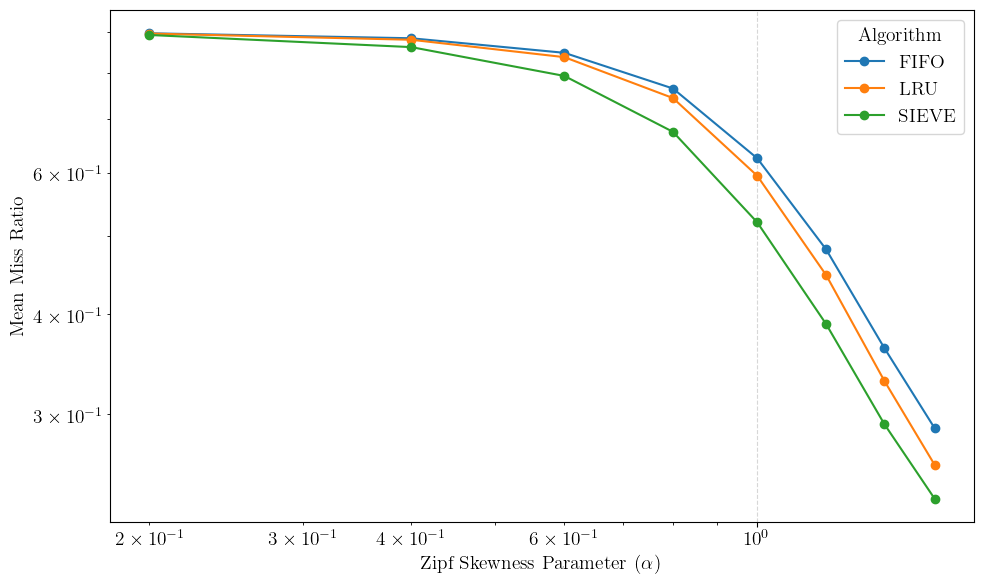

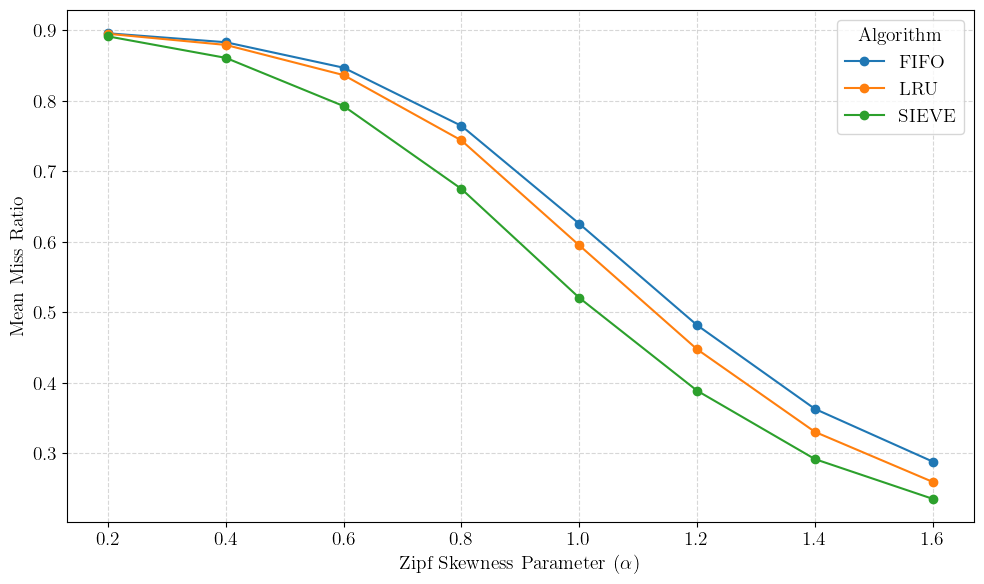

In [8]:
def plot_miss_ratio_vs_alpha(save=False, title=True, log=False):
    # Aggregate mean miss ratio by algorithm and alpha
    zipf_agg = results_df.groupby(['algorithm', 'alpha'])['miss_ratio'].mean().reset_index()

    plt.figure(figsize=(10, 6))
    for algo in zipf_agg['algorithm'].unique():
        df_algo = zipf_agg[zipf_agg['algorithm'] == algo]
        plt.plot(df_algo['alpha'], df_algo['miss_ratio'], 
                marker='o', label=algo, color=ALGORITHM_COLORS.get(algo, 'black'))

    plt.xlabel(r'Zipf Skewness Parameter ($\alpha$)', fontsize=AXIS_FONT_SIZE)
    plt.ylabel('Mean Miss Ratio', fontsize=AXIS_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)

    if log:
        plt.xscale('log')
        plt.yscale('log')

    if title: plt.title(r'Miss Ratio vs. Zipf Skewness Parameter ($\alpha$)', fontsize=TITLE_FONT_SIZE)
    plt.legend(title='Algorithm', fontsize=LEGEND_FONT_SIZE, title_fontsize=LEGEND_FONT_SIZE)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    if save: plt.savefig(os.path.join(FIGURES_SIMULATIONS_DIR, f"miss_ratio_vs_alpha{'_log' if log else ''}{'_no_title' if not title else ''}.pdf"), bbox_inches='tight')
    plt.show()

plot_miss_ratio_vs_alpha(save=True, title=False, log=True)
plot_miss_ratio_vs_alpha(save=True, title=False, log=False)

### SIEVE advantage plot

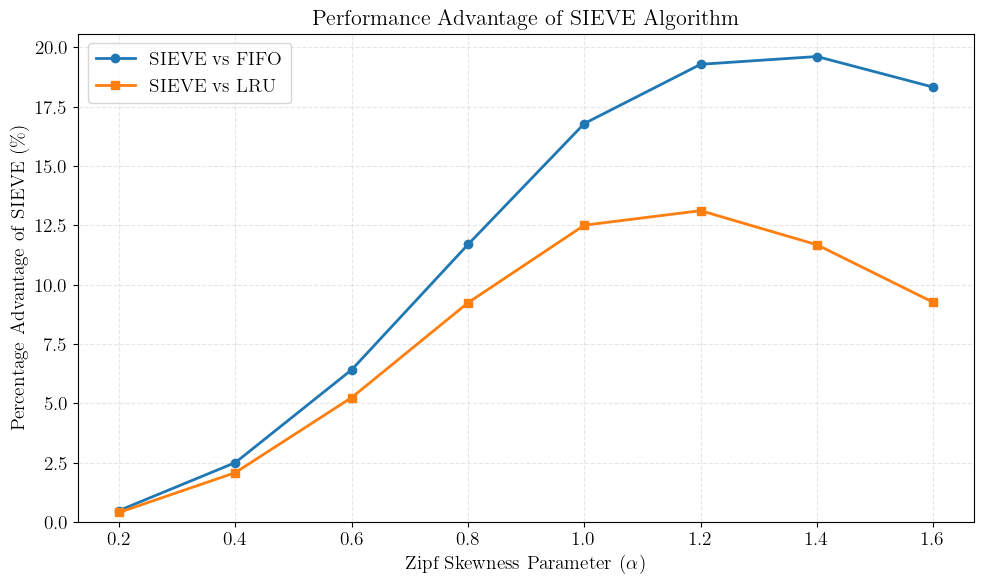

In [9]:
def plot_sieve_advantage(save=False, title=True):
    """
    Plot the percentage advantage of SIEVE compared to FIFO and LRU algorithms.
    Percentage advantage = (baseline_miss_ratio - sieve_miss_ratio) / baseline_miss_ratio * 100
    """
    # Use the already computed zipf_agg data
    pivot_data = zipf_agg.pivot(index='alpha', columns='algorithm', values='miss_ratio')
    
    # Calculate percentage advantages
    sieve_vs_fifo = ((pivot_data['FIFO'] - pivot_data['SIEVE']) / pivot_data['FIFO'] * 100)
    sieve_vs_lru = ((pivot_data['LRU'] - pivot_data['SIEVE']) / pivot_data['LRU'] * 100)
    
    plt.figure(figsize=(10, 6))
    
    # Plot percentage advantages
    plt.plot(pivot_data.index, sieve_vs_fifo, marker='o', linewidth=2, 
             label='SIEVE vs FIFO', color=FIFO_COLOR, markersize=6)
    plt.plot(pivot_data.index, sieve_vs_lru, marker='s', linewidth=2, 
             label='SIEVE vs LRU', color=LRU_COLOR, markersize=6)
    
    plt.xlabel(r'Zipf Skewness Parameter ($\alpha$)', fontsize=AXIS_FONT_SIZE)
    plt.ylabel('Percentage Advantage of SIEVE (\%)', fontsize=AXIS_FONT_SIZE)

    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)
    
    # Set y-axis to start at 0
    plt.ylim(bottom=0)
    
    if title:
        plt.title('Performance Advantage of SIEVE Algorithm', fontsize=TITLE_FONT_SIZE)
    
    plt.legend(fontsize=LEGEND_FONT_SIZE)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    if save:
        plt.savefig(os.path.join(FIGURES_SIMULATIONS_DIR, f"sieve_advantage{'_no_title' if not title else ''}.pdf"), bbox_inches='tight')
    
    plt.show()

plot_sieve_advantage(save=False, title=True)

## Miss ratio vs. alpha + relative cache size

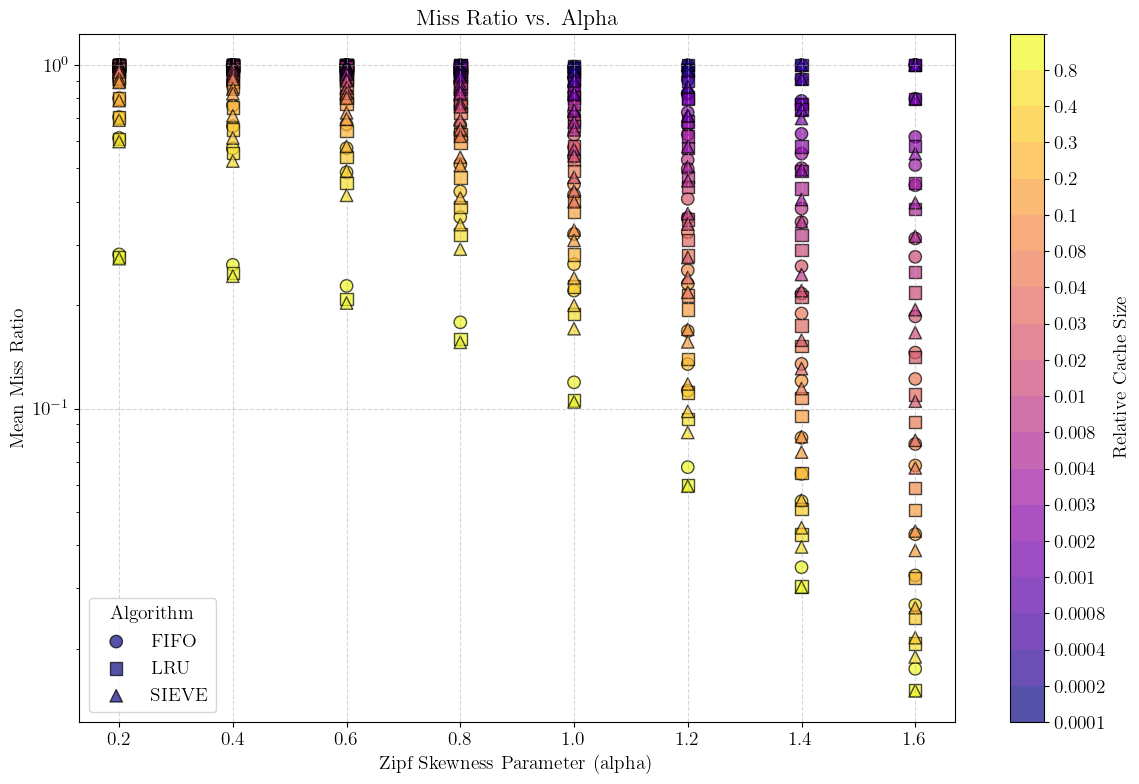

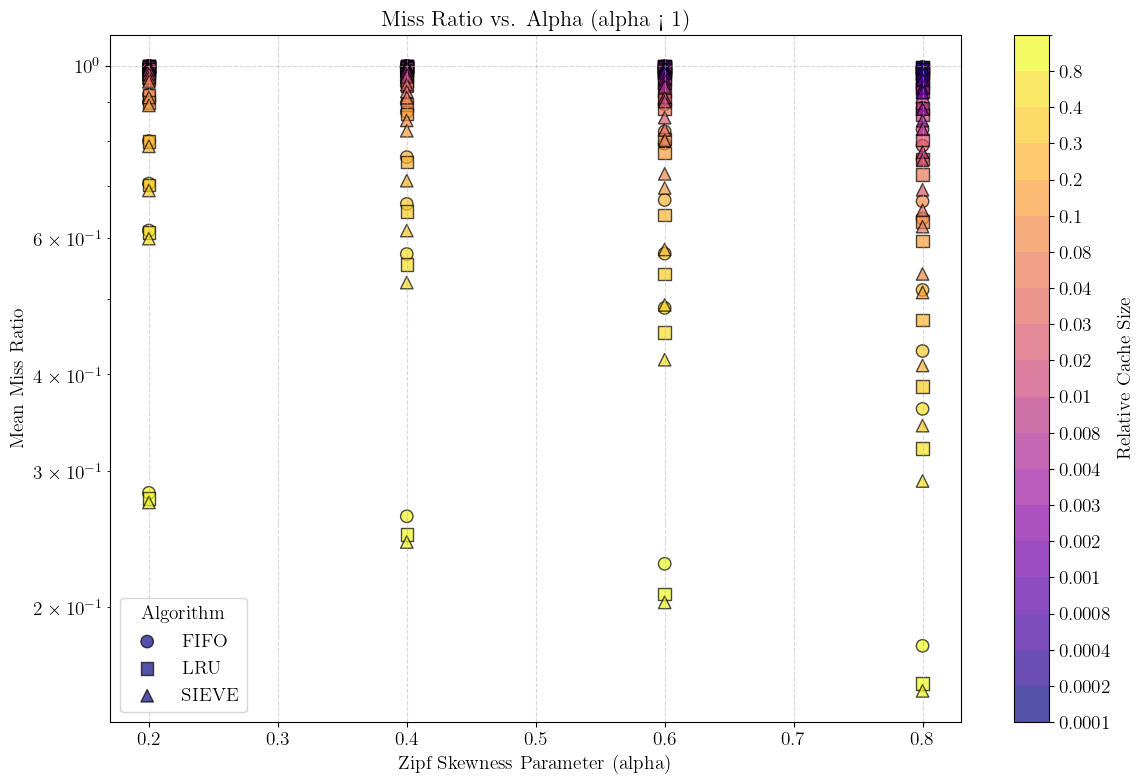

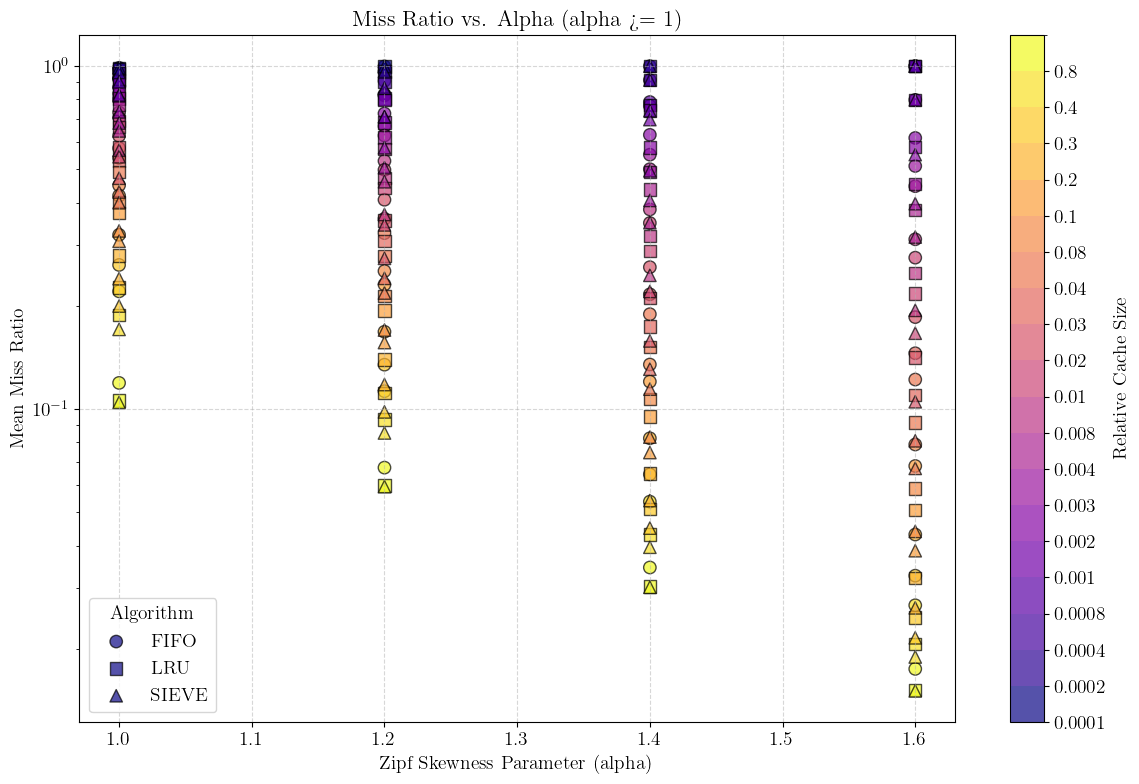

In [10]:
# Pivot the data to have (alpha, cache_size_relative_rounded) as x, algorithm as lines
pivot_df = results_df.groupby(['algorithm', 'alpha', 'cache_size_relative_rounded'])['miss_ratio'].mean().reset_index()

# Assign a unique marker for each algorithm
markers = {
    'FIFO': 'o',
    'LRU': 's', 
    'SIEVE': '^'
}

cmap = 'plasma'

# Only use the specified relative cache sizes
relevant_sizes = sorted(pivot_df['cache_size_relative_rounded'].unique())
filtered_df = pivot_df[pivot_df['cache_size_relative_rounded'].isin(relevant_sizes)]

# # Create a colormap and norm that matches the relevant sizes
cmap = plt.get_cmap('plasma', len(relevant_sizes))
norm = mpl.colors.BoundaryNorm(boundaries=np.append(relevant_sizes, relevant_sizes[-1]+0.001), ncolors=len(relevant_sizes))

# Split the filtered_df into two based on alpha
below_1 = filtered_df[filtered_df['alpha'] < 1]
above_eq_1 = filtered_df[filtered_df['alpha'] >= 1]

def plot_scatter(df, title=None, save=False):
    plt.figure(figsize=(12, 8))
    scs = []
    for algo in df['algorithm'].unique():
        df_algo = df[df['algorithm'] == algo]
        sc = plt.scatter(
            df_algo['alpha'],
            df_algo['miss_ratio'],
            c=df_algo['cache_size_relative_rounded'],
            cmap=cmap,
            norm=norm,
            s=80,
            alpha=0.7,
            marker=markers.get(algo, 'o'),
            label=algo,
            edgecolor='black'
        )
        scs.append(sc)
    plt.xlabel('Zipf Skewness Parameter (alpha)', fontsize=AXIS_FONT_SIZE)
    plt.ylabel('Mean Miss Ratio', fontsize=AXIS_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)

    if title: plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.yscale('log')
    cbar = plt.colorbar(scs[0], ticks=relevant_sizes, label='Relative Cache Size')
    cbar.ax.set_yticklabels([str(s) for s in relevant_sizes])
    
    # Set colorbar font sizes
    cbar.ax.tick_params(labelsize=TICKS_FONT_SIZE)
    cbar.set_label('Relative Cache Size', fontsize=LEGEND_FONT_SIZE)
    
    plt.legend(title='Algorithm', fontsize=LEGEND_FONT_SIZE, title_fontsize=LEGEND_FONT_SIZE)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    if save:
        plt.savefig(os.path.join(FIGURES_SIMULATIONS_DIR, f"miss_ratio_heat_map{'_no_title' if not title else ''}.pdf"), bbox_inches='tight')

    plt.show()


plot_scatter(filtered_df, "Miss Ratio vs. Alpha")
plot_scatter(below_1, 'Miss Ratio vs. Alpha (alpha < 1)')
plot_scatter(above_eq_1, 'Miss Ratio vs. Alpha (alpha >= 1)')

## Miss ratio distribution

### Statistics

In [11]:
# Comprehensive Miss Ratio Statistics Table
print("=" * 80)
print("COMPREHENSIVE MISS RATIO STATISTICS BY ALGORITHM")
print("=" * 80)

# Calculate comprehensive statistics for each algorithm
stats_data = []
for algo in sorted(results_df['algorithm'].unique()):
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    
    # Calculate statistics
    mean_val = data.mean()
    median_val = data.median()
    std_val = data.std()
    min_val = data.min()
    max_val = data.max()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr_val = q3 - q1
    count_val = len(data)
    
    stats_data.append({
        'Algorithm': algo,
        'Count': count_val,
        'Mean': mean_val,
        'Median': median_val,
        'Std Dev': std_val,
        'Min': min_val,
        'Max': max_val,
        'Q1': q1,
        'Q3': q3,
        'IQR': iqr_val
    })

# Create DataFrame for better formatting
stats_df = pd.DataFrame(stats_data)

# Print formatted table
print(f"{'Algorithm':<10} {'Count':<7} {'Mean':<8} {'Median':<8} {'Std Dev':<8} {'Min':<8} {'Max':<8} {'Q1':<8} {'Q3':<8} {'IQR':<8}")
print("-" * 80)

for _, row in stats_df.iterrows():
    print(f"{row['Algorithm']:<10} {row['Count']:<7.0f} {row['Mean']:<8.4f} {row['Median']:<8.4f} "
          f"{row['Std Dev']:<8.4f} {row['Min']:<8.4f} {row['Max']:<8.4f} {row['Q1']:<8.4f} "
          f"{row['Q3']:<8.4f} {row['IQR']:<8.4f}")

print("=" * 80)

# Additional insights
print("\nKEY INSIGHTS:")
print("-" * 40)

# Best performing algorithm (lowest mean)
best_algo = stats_df.loc[stats_df['Mean'].idxmin(), 'Algorithm']
best_mean = stats_df.loc[stats_df['Mean'].idxmin(), 'Mean']
print(f"Best performing algorithm (lowest mean): {best_algo} ({best_mean:.4f})")

# Most consistent algorithm (lowest std dev)
most_consistent = stats_df.loc[stats_df['Std Dev'].idxmin(), 'Algorithm']
lowest_std = stats_df.loc[stats_df['Std Dev'].idxmin(), 'Std Dev']
print(f"Most consistent algorithm (lowest std dev): {most_consistent} ({lowest_std:.4f})")

# Algorithm with smallest range
stats_df['Range'] = stats_df['Max'] - stats_df['Min']
smallest_range = stats_df.loc[stats_df['Range'].idxmin(), 'Algorithm']
range_val = stats_df.loc[stats_df['Range'].idxmin(), 'Range']
print(f"Smallest range: {smallest_range} ({range_val:.4f})")

print("\n" + "=" * 80)

# Save statistics table to CSV
stats_df_export = stats_df.round(6)
stats_df_export.to_csv(os.path.join(TABLES_DIR, 'miss_ratio_statistics_by_algorithm.csv'), index=False)

# Create a comparison table showing relative performance
print("\n" + "=" * 60)
print("RELATIVE PERFORMANCE COMPARISON")
print("=" * 60)

# Use SIEVE as baseline for comparison
sieve_stats = stats_df[stats_df['Algorithm'] == 'SIEVE'].iloc[0]

print(f"{'Metric':<15} {'FIFO vs SIEVE':<15} {'LRU vs SIEVE':<15}")
print("-" * 60)

for metric in ['Mean', 'Median', 'Std Dev']:
    fifo_val = stats_df[stats_df['Algorithm'] == 'FIFO'][metric].iloc[0]
    lru_val = stats_df[stats_df['Algorithm'] == 'LRU'][metric].iloc[0]
    sieve_val = sieve_stats[metric]
    
    fifo_diff = ((fifo_val - sieve_val) / sieve_val * 100)
    lru_diff = ((lru_val - sieve_val) / sieve_val * 100)
    
    print(f"{metric:<15} {fifo_diff:>+12.2f}% {lru_diff:>+12.2f}%")

print("=" * 60)
print("Note: Positive values indicate worse performance than SIEVE")

COMPREHENSIVE MISS RATIO STATISTICS BY ALGORITHM
Algorithm  Count   Mean     Median   Std Dev  Min      Max      Q1       Q3       IQR     
--------------------------------------------------------------------------------
FIFO       28371   0.6523   0.7688   0.3355   0.0111   1.0000   0.3420   0.9733   0.6313  
LRU        28371   0.6324   0.7399   0.3469   0.0089   1.0000   0.2929   0.9724   0.6795  
SIEVE      28371   0.5909   0.6483   0.3491   0.0088   1.0000   0.2464   0.9472   0.7008  

KEY INSIGHTS:
----------------------------------------
Best performing algorithm (lowest mean): SIEVE (0.5909)
Most consistent algorithm (lowest std dev): FIFO (0.3355)
Smallest range: FIFO (0.9889)


RELATIVE PERFORMANCE COMPARISON
Metric          FIFO vs SIEVE   LRU vs SIEVE   
------------------------------------------------------------
Mean                  +10.39%        +7.02%
Median                +18.59%       +14.13%
Std Dev                -3.89%        -0.64%
Note: Positive values indicate 

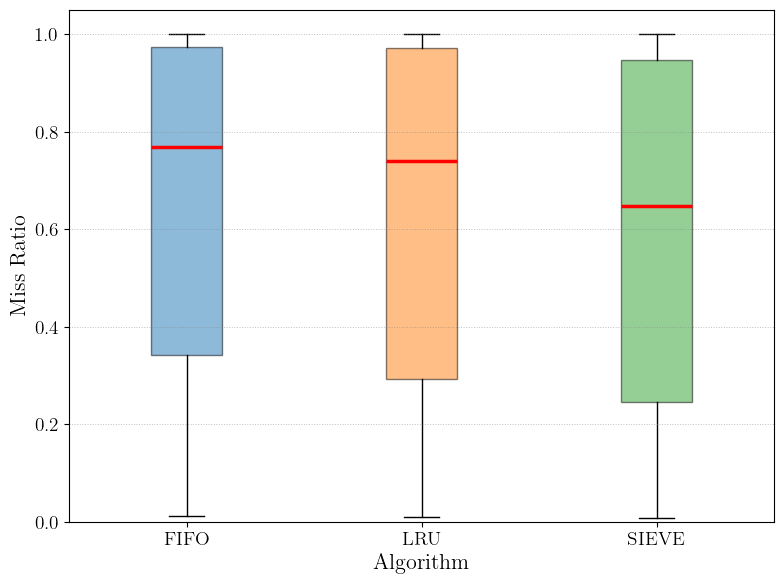

In [12]:
def plot_boxplot_miss_ratio(save=False, title=True):
    plt.figure(figsize=(8, 6))

    # Prepare data for colored boxplots
    box_data = [results_df[results_df['algorithm'] == algo]['miss_ratio'] for algo in results_df['algorithm'].unique()]
    algorithms = results_df['algorithm'].unique()

    # Create boxplot with colors
    bp = plt.boxplot(box_data, labels=algorithms, patch_artist=True, medianprops=dict(color='red', linewidth=2.5))

    # Color each box with algorithm-specific colors
    for i, (patch, algo) in enumerate(zip(bp['boxes'], algorithms)):
        patch.set_facecolor(ALGORITHM_COLORS.get(algo, 'gray'))
        patch.set_alpha(0.5)

    if title: plt.title('Miss Ratio Distribution by Algorithm', fontsize=16)
    plt.xlabel('Algorithm', fontsize=16)
    plt.ylabel('Miss Ratio', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(0, 1.05)

    # Add horizontal grid lines
    ax = plt.gca()
    for y in ax.get_yticks():
        ax.axhline(y, color='gray', linestyle=':', linewidth=0.7, alpha=0.5)

    plt.tight_layout()

    if save:
        plt.savefig(os.path.join(FIGURES_SIMULATIONS_DIR, f"miss_ratio_distribution{'_no_title' if not title else ''}.pdf"), bbox_inches='tight')

    plt.show()

plot_boxplot_miss_ratio(title=False, save=True)

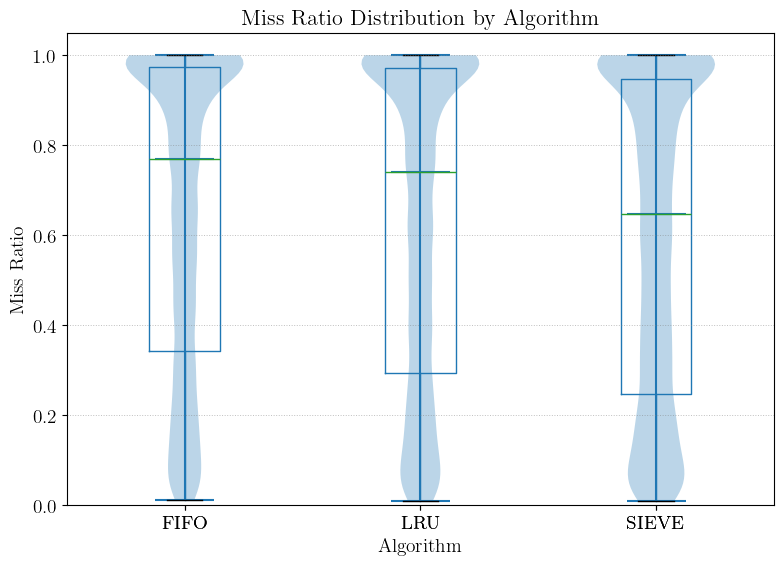

In [13]:
plt.figure(figsize=(8, 6))
subset_violin = [results_df[results_df['algorithm'] == algo]['miss_ratio'] for algo in results_df['algorithm'].unique()]
plt.violinplot(subset_violin, showmeans=False, showmedians=True)
plt.xticks(range(1, len(results_df['algorithm'].unique()) + 1), results_df['algorithm'].unique())
ax = plt.gca()
results_df.boxplot(column='miss_ratio', by='algorithm', ax=ax, grid=False)
plt.title('Miss Ratio Distribution by Algorithm')
plt.suptitle('')
plt.xlabel('Algorithm')
plt.ylabel('Miss Ratio')
plt.tight_layout()
ax.set_ylim(0, 1.05)

for y in ax.get_yticks():
    ax.axhline(y, color='gray', linestyle=':', linewidth=0.7, alpha=0.5)

plt.show()

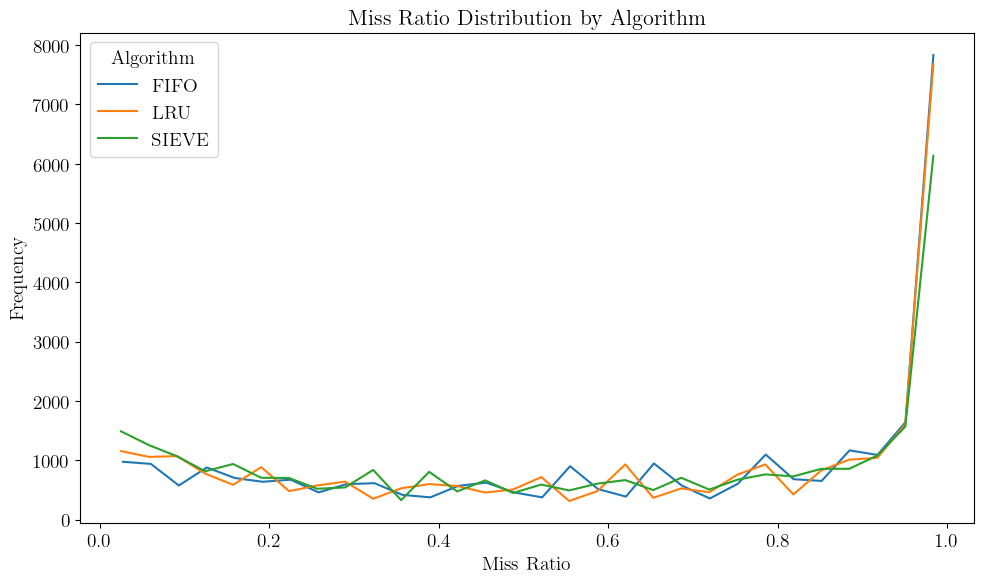

In [14]:
for algo in results_df['algorithm'].unique():
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    counts, bin_edges = np.histogram(data, bins=30)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(bin_centers, counts, label=algo, color=ALGORITHM_COLORS.get(algo, 'black'))
plt.xlabel('Miss Ratio')
plt.ylabel('Frequency')
plt.title('Miss Ratio Distribution by Algorithm')
plt.legend(title='Algorithm')
plt.tight_layout()
plt.show()

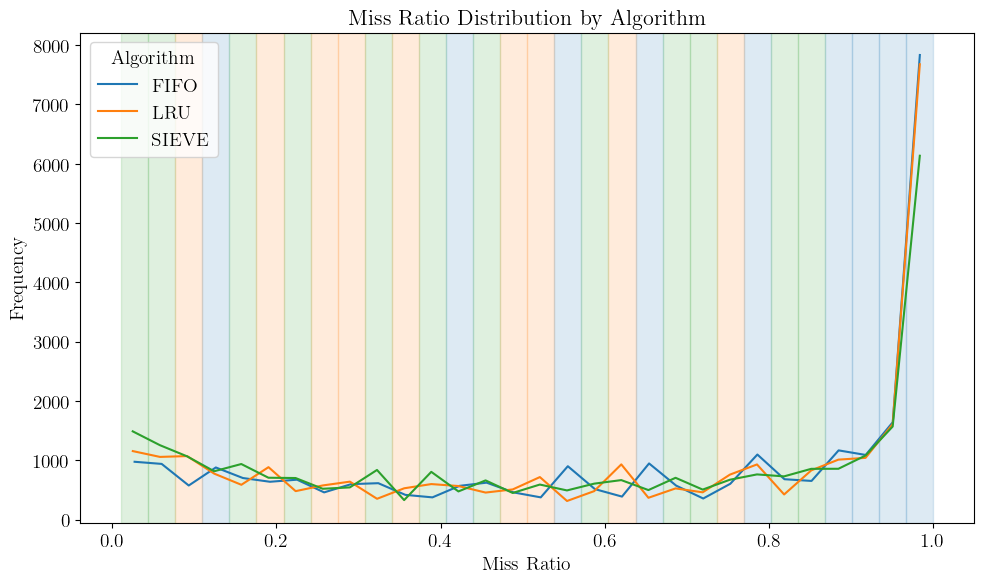

In [15]:
plt.figure(figsize=(10, 6))

# Store histogram data for each algorithm
hist_data = {}
bin_edges = None

for algo in results_df['algorithm'].unique():
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    counts, edges = np.histogram(data, bins=30)
    bin_centers = (edges[:-1] + edges[1:]) / 2
    hist_data[algo] = counts
    if bin_edges is None:
        bin_edges = edges
    plt.plot(bin_centers, counts, label=algo, color=ALGORITHM_COLORS.get(algo, 'black'))

# Find the algorithm with the highest frequency for each bin
all_counts = np.array([hist_data[algo] for algo in results_df['algorithm'].unique()])
max_algo_idx = np.argmax(all_counts, axis=0)
algos = list(results_df['algorithm'].unique())
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(len(bin_edges) - 1):
    algo_idx = max_algo_idx[i]
    plt.axvspan(bin_edges[i], bin_edges[i+1], color=colors[algo_idx], alpha=0.15)

plt.xlabel('Miss Ratio')
plt.ylabel('Frequency')
plt.title('Miss Ratio Distribution by Algorithm')
plt.legend(title='Algorithm')
plt.tight_layout()
plt.show()

## Cumulative probability

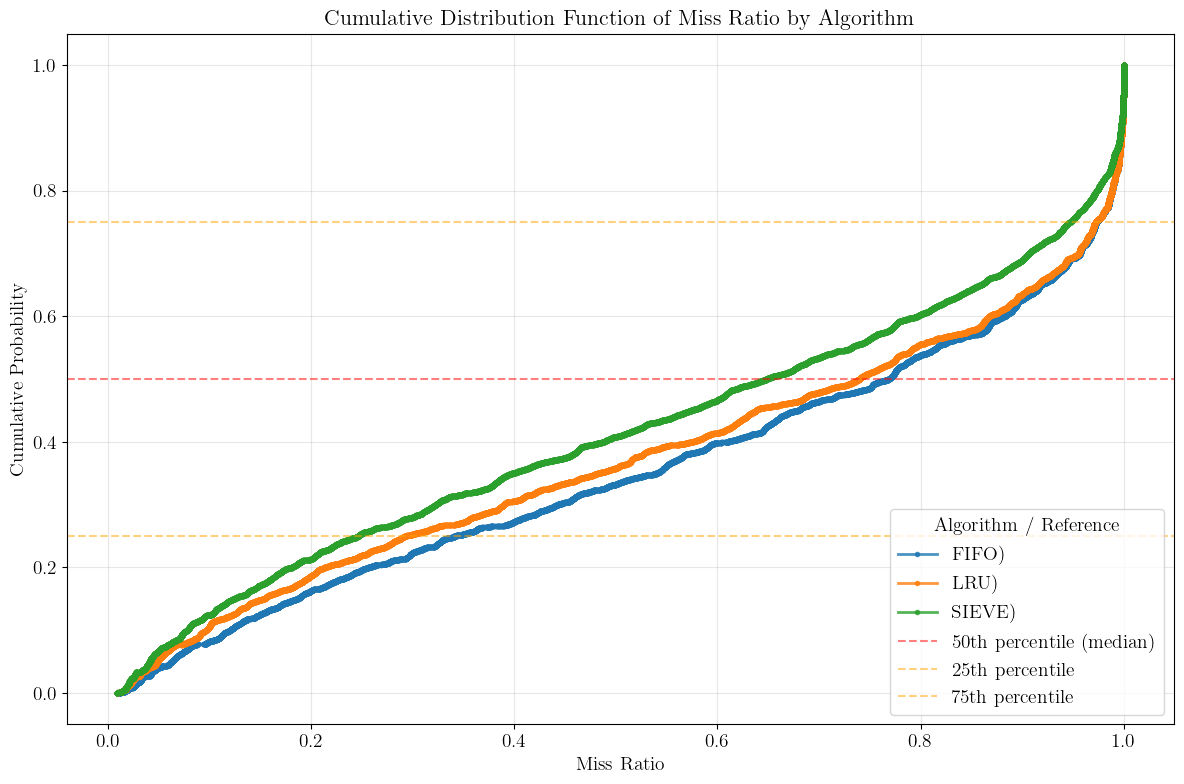

Percentile Analysis for Miss Ratio by Algorithm:
Algorithm  25th %   50th %   75th %   90th %   95th %  
------------------------------------------------------------
FIFO       0.3420   0.7688   0.9733   0.9985   0.9998  
LRU        0.2929   0.7399   0.9724   0.9985   0.9998  
SIEVE      0.2464   0.6483   0.9472   0.9973   0.9998  

Performance Comparison (Probability of Miss Ratio < 0.1):
------------------------------------------------------------
FIFO: 0.082 (8.2%)
LRU: 0.106 (10.6%)
SIEVE: 0.124 (12.4%)

Performance Comparison (Probability of Miss Ratio < 0.2):
------------------------------------------------------------
FIFO: 0.163 (16.3%)
LRU: 0.187 (18.7%)
SIEVE: 0.213 (21.3%)


In [16]:
# Cumulative probability plot for miss ratio by algorithm
plt.figure(figsize=(12, 8))

# Create cumulative probability plots for each algorithm
for algo in results_df['algorithm'].unique():
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    
    # Sort the data
    sorted_data = np.sort(data)
    
    # Calculate cumulative probabilities (empirical CDF)
    n = len(sorted_data)
    y = np.arange(1, n + 1) / n
    
    # Plot the CDF
    plt.plot(sorted_data, y, marker='o', markersize=3, linewidth=2, 
             label=f'{algo})', alpha=0.8, color=ALGORITHM_COLORS.get(algo, 'black'))

plt.xlabel('Miss Ratio')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Function of Miss Ratio by Algorithm')
plt.legend(title='Algorithm')
plt.grid(True, alpha=0.3)

# Add some reference lines
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='50th percentile (median)')
plt.axhline(y=0.25, color='orange', linestyle='--', alpha=0.5, label='25th percentile')
plt.axhline(y=0.75, color='orange', linestyle='--', alpha=0.5, label='75th percentile')

# Update legend to include reference lines
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, title='Algorithm / Reference', loc='lower right')

plt.tight_layout()
plt.show()

# Print percentile analysis
print("Percentile Analysis for Miss Ratio by Algorithm:")
print("=" * 60)
print(f"{'Algorithm':<10} {'25th %':<8} {'50th %':<8} {'75th %':<8} {'90th %':<8} {'95th %':<8}")
print("-" * 60)

for algo in results_df['algorithm'].unique():
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    p25 = np.percentile(data, 25)
    p50 = np.percentile(data, 50)  # median
    p75 = np.percentile(data, 75)
    p90 = np.percentile(data, 90)
    p95 = np.percentile(data, 95)
    
    print(f"{algo:<10} {p25:<8.4f} {p50:<8.4f} {p75:<8.4f} {p90:<8.4f} {p95:<8.4f}")

# Performance comparison analysis
print(f"\nPerformance Comparison (Probability of Miss Ratio < 0.1):")
print("-" * 60)
for algo in results_df['algorithm'].unique():
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    prob_low_miss = (data < 0.1).mean()
    print(f"{algo}: {prob_low_miss:.3f} ({prob_low_miss*100:.1f}%)")

print(f"\nPerformance Comparison (Probability of Miss Ratio < 0.2):")
print("-" * 60)
for algo in results_df['algorithm'].unique():
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    prob_low_miss = (data < 0.2).mean()
    print(f"{algo}: {prob_low_miss:.3f} ({prob_low_miss*100:.1f}%)")

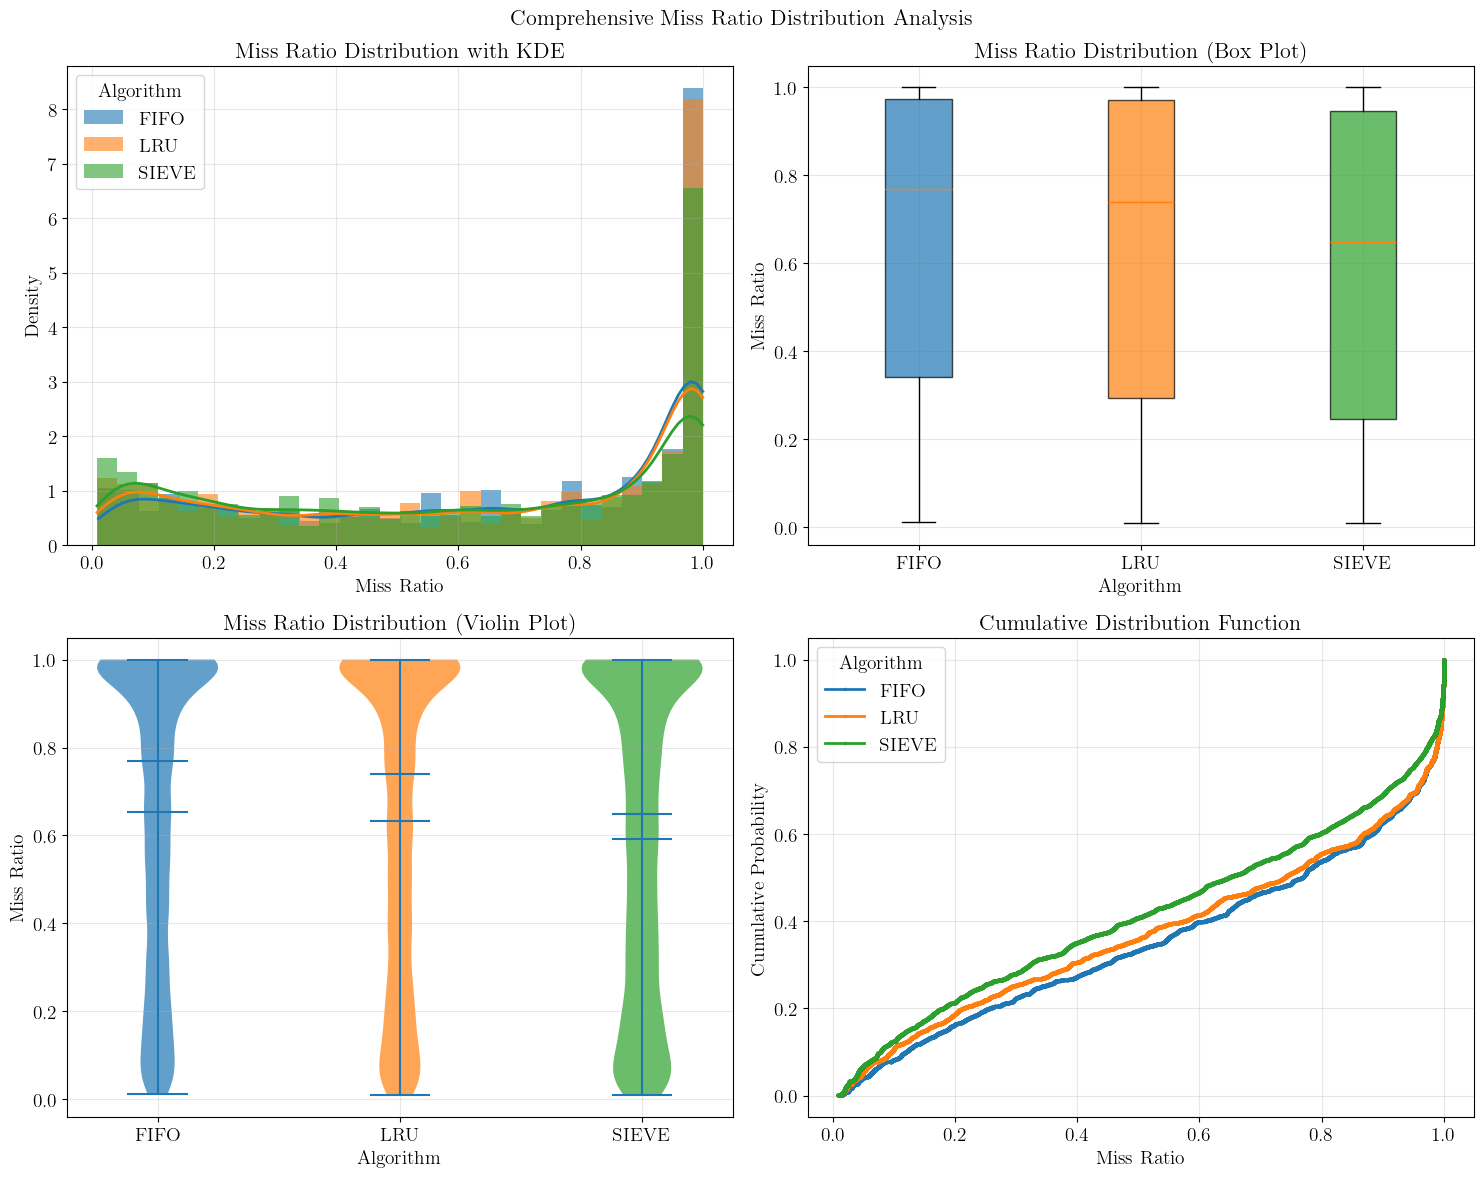

\nSummary Statistics by Algorithm:
\nFIFO:
  Mean: 0.6523
  Median: 0.7688
  Std Dev: 0.3355
  Min: 0.0111
  Max: 1.0000
  25th percentile: 0.3420
  75th percentile: 0.9733
\nLRU:
  Mean: 0.6324
  Median: 0.7399
  Std Dev: 0.3469
  Min: 0.0089
  Max: 1.0000
  25th percentile: 0.2929
  75th percentile: 0.9724
\nSIEVE:
  Mean: 0.5909
  Median: 0.6483
  Std Dev: 0.3491
  Min: 0.0088
  Max: 1.0000
  25th percentile: 0.2464
  75th percentile: 0.9472


In [17]:
# Comprehensive miss ratio distribution analysis
from scipy import stats

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Histogram with density curves
for algo in results_df['algorithm'].unique():
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    
    # Histogram
    ax1.hist(data, bins=30, alpha=0.6, label=algo, density=True, 
             color=ALGORITHM_COLORS.get(algo, 'gray'))
    
    # Kernel density estimation
    kde = stats.gaussian_kde(data)
    x_range = np.linspace(data.min(), data.max(), 100)
    ax1.plot(x_range, kde(x_range), linewidth=2, 
             color=ALGORITHM_COLORS.get(algo, 'black'))

ax1.set_xlabel('Miss Ratio')
ax1.set_ylabel('Density')
ax1.set_title('Miss Ratio Distribution with KDE')
ax1.legend(title='Algorithm')
ax1.grid(True, alpha=0.3)

# 2. Box plots
box_data = [results_df[results_df['algorithm'] == algo]['miss_ratio'] for algo in results_df['algorithm'].unique()]
bp = ax2.boxplot(box_data, labels=results_df['algorithm'].unique(), patch_artist=True)

# Color the box plots
algorithms_list = list(results_df['algorithm'].unique())
for i, (patch, algo) in enumerate(zip(bp['boxes'], algorithms_list)):
    patch.set_facecolor(ALGORITHM_COLORS.get(algo, 'gray'))
    patch.set_alpha(0.7)

ax2.set_xlabel('Algorithm')
ax2.set_ylabel('Miss Ratio')
ax2.set_title('Miss Ratio Distribution (Box Plot)')
ax2.grid(True, alpha=0.3)

# 3. Violin plots
parts = ax3.violinplot(box_data, showmeans=True, showmedians=True)
for i, (part, algo) in enumerate(zip(parts['bodies'], algorithms_list)):
    part.set_facecolor(ALGORITHM_COLORS.get(algo, 'gray'))
    part.set_alpha(0.7)

ax3.set_xticks(range(1, len(results_df['algorithm'].unique()) + 1))
ax3.set_xticklabels(results_df['algorithm'].unique())
ax3.set_xlabel('Algorithm')
ax3.set_ylabel('Miss Ratio')
ax3.set_title('Miss Ratio Distribution (Violin Plot)')
ax3.grid(True, alpha=0.3)

# 4. Cumulative distribution function
for algo in results_df['algorithm'].unique():
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    sorted_data = np.sort(data)
    y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    ax4.plot(sorted_data, y, marker='.', markersize=3, label=algo, 
             linewidth=2, color=ALGORITHM_COLORS.get(algo, 'black'))

ax4.set_xlabel('Miss Ratio')
ax4.set_ylabel('Cumulative Probability')
ax4.set_title('Cumulative Distribution Function')
ax4.legend(title='Algorithm')
ax4.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Miss Ratio Distribution Analysis', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\\nSummary Statistics by Algorithm:")
print("=" * 50)
for algo in results_df['algorithm'].unique():
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    print(f"\\n{algo}:")
    print(f"  Mean: {data.mean():.4f}")
    print(f"  Median: {data.median():.4f}")
    print(f"  Std Dev: {data.std():.4f}")
    print(f"  Min: {data.min():.4f}")
    print(f"  Max: {data.max():.4f}")
    print(f"  25th percentile: {data.quantile(0.25):.4f}")
    print(f"  75th percentile: {data.quantile(0.75):.4f}")